In [1]:
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Settings
root_dir = "Background"
screen_states = ["screen on", "screen off"]
repeats = ["repeat 1", "repeat 2", "repeat 3"]
ns_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
txtdata = ["counts", "timestamps", "timestamps_channel"]

In [2]:
def getData():
    # Initialize deeply nested defaultdict
    def nested_dict():
        return defaultdict(nested_dict)

    data = nested_dict()

    # Read the files
    for screen_state in screen_states:
        for repeat in repeats:
            for ns in ns_values:
                filename = f"coincWin_{ns}ns.txt"
                file_path = os.path.join(root_dir, screen_state, repeat, filename)

                try:
                    with open(file_path, "r") as f:
                        for line, dat in zip(f, txtdata):
                            data[screen_state][repeat][ns][dat] = np.array([int(x.strip()) for x in line.strip().strip("[]").split(",")])
                except FileNotFoundError:
                    print(f"Missing: {file_path}")
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    return data

data = getData()

In [132]:
screenoff_countdata_1 = np.vstack(tuple(data["screen off"]["repeat 1"][ns]["counts"] for ns in ns_values))
screenoff_countdata_2 = np.vstack(tuple(data["screen off"]["repeat 2"][ns]["counts"] for ns in ns_values))
screenoff_countdata_3 = np.vstack(tuple(data["screen off"]["repeat 3"][ns]["counts"] for ns in ns_values))
screenon_countdata_1 = np.vstack(tuple(data["screen on"]["repeat 1"][ns]["counts"] for ns in ns_values))
screenon_countdata_2 = np.vstack(tuple(data["screen on"]["repeat 2"][ns]["counts"] for ns in ns_values))
screenon_countdata_3 = np.vstack(tuple(data["screen on"]["repeat 3"][ns]["counts"] for ns in ns_values))

The following graphs technically have different coincidence windows, but that shouldnt affect the total count

Screen on data:

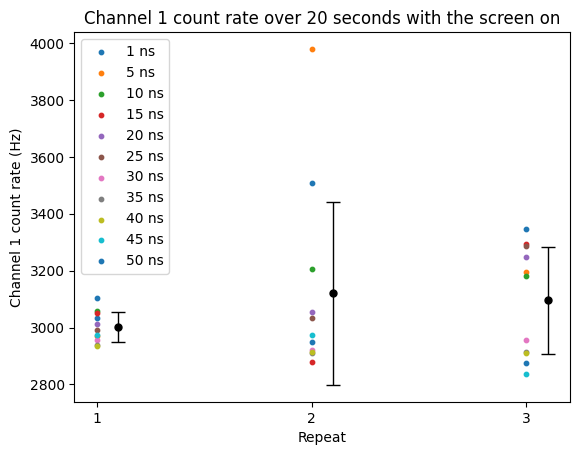

Average of the means: 3072.6242424242423 +- 29.446941150622788 Hz
Average stdev: 186.7700421691383 Hz


In [133]:
# Plot repeats
for i in range(11):
    plt.scatter(1, screenon_countdata_1[i,1]/20, label = f"{ns_values[i]} ns", color=f"C{i}", s=10)
    plt.scatter(2, screenon_countdata_2[i,1]/20, color=f"C{i}", s=10)
    plt.scatter(3, screenon_countdata_3[i,1]/20, color=f"C{i}", s=10)

# Calculate means and stdevs of each repeat
means = np.array([np.mean(screenon_countdata_1[:,1]/20), np.mean(screenon_countdata_2[:,1]/20), np.mean(screenon_countdata_3[:,1]/20)])
stdevs = np.array([np.std(screenon_countdata_1[:,1]/20), np.std(screenon_countdata_2[:,1]/20), np.std(screenon_countdata_3[:,1]/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 1 count rate over 20 seconds with the screen on")
plt.ylabel("Channel 1 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend()
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

Some weird spread in repeat 2, perhaps due to opening and closing different coloured tabs on the computer. Also note that we were moving around and causing reflections

Screen off data:

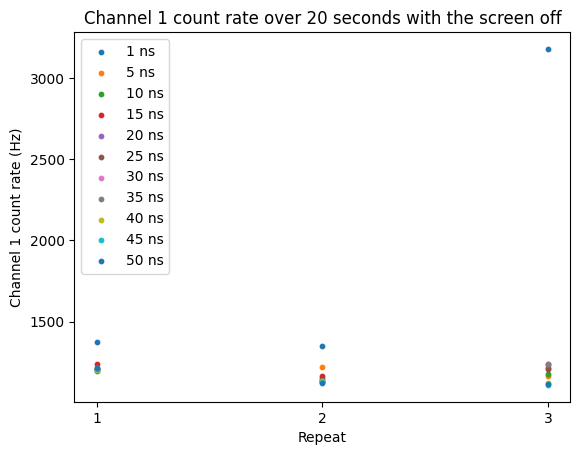

In [134]:
for i in range(11):
    plt.scatter(1, screenoff_countdata_1[i,1]/20, label = f"{ns_values[i]} ns", color=f"C{i}", s=10)
    plt.scatter(2, screenoff_countdata_2[i,1]/20, color=f"C{i}", s=10)
    plt.scatter(3, screenoff_countdata_3[i,1]/20, color=f"C{i}", s=10)
plt.title("Channel 1 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 1 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend()
plt.show()

Weird anomaly in the 3rd repeat, possibly due to some accidental lighting from a phone or watch??? It alignes with the count rates we see with the screen on setting, so its likely something as intense as the screen was on for enough time

Looing at that anomalous plot (estimating the countrate over windows of 0.1 s):

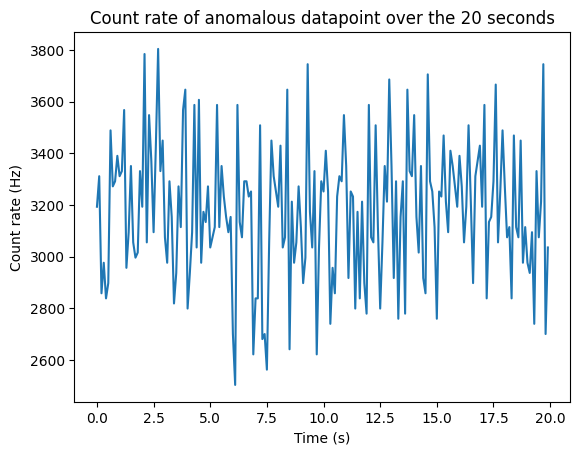

In [135]:
ch1_timestamps = []
for channel, timestamp in zip(data["screen off"]["repeat 3"][1]["timestamps_channel"], data["screen off"]["repeat 3"][1]["timestamps"]):
    if channel == 1:
        ch1_timestamps.append(timestamp)
ch1_timestamps = np.array(ch1_timestamps)

# Guess initial t0 from minimum timestamp data
t0 = data["screen off"]["repeat 3"][1]["timestamps"].min()
times_sec = (ch1_timestamps - t0) / 1e12

# Define bin edges for 0.1s bins
bin_width = 0.1  # seconds
max_time = times_sec.max()
bins = np.arange(0, max_time + bin_width, bin_width)

# Histogram counts in each bin
counts, bin_edges = np.histogram(times_sec, bins=bins)

# The timestamps have a buffer so they likely missed some counts that were measured
# Normalise to total counts and plot
plt.plot(bins[:-2], 10*counts[:-1]/(len(ch1_timestamps)/screenoff_countdata_3[0,1]))
plt.title("Count rate of anomalous datapoint over the 20 seconds")
plt.xlabel("Time (s)")
plt.ylabel("Count rate (Hz)")
plt.show()

Something was continuously screwing with our data that entire dataset. However we can afford to throw it away since we have 32 other datasets that roughly agree

Redoing the screen off graph neglecting the anomale:

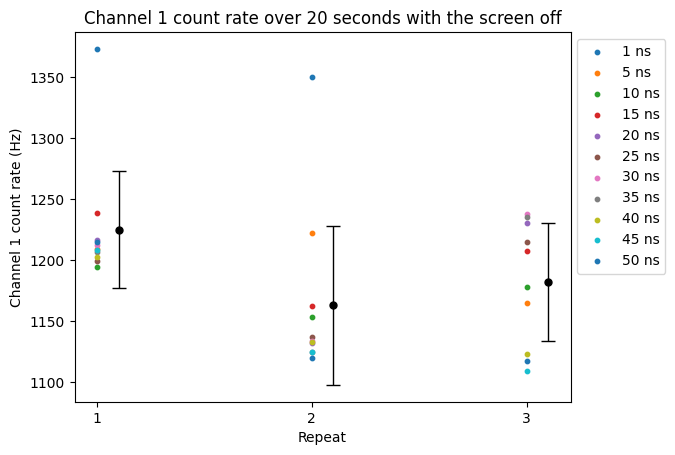

Average of the means: 1190.0525757575758 +- 14.978002658955221 Hz
Average stdev: 53.82688665599707 Hz


In [136]:
# Remove anomaly
new_screenoff_countdata_3 = screenoff_countdata_3[1:,1]

# PLot data
for i in range(11):
    plt.scatter(1, screenoff_countdata_1[i,1]/20, label = f"{ns_values[i]} ns", color=f"C{i}", s=10)
    plt.scatter(2, screenoff_countdata_2[i,1]/20, color=f"C{i}", s=10)
    if i != 0:
        plt.scatter(3, new_screenoff_countdata_3[i-1]/20, color=f"C{i}", s=10)


# Calculate means and stdevs of each repeat
means = np.array([np.mean(screenoff_countdata_1[:,1]/20), np.mean(screenoff_countdata_2[:,1]/20), np.mean(new_screenoff_countdata_3/20)])
stdevs = np.array([np.std(screenoff_countdata_1[:,1]/20), np.std(screenoff_countdata_2[:,1]/20), np.std(new_screenoff_countdata_3/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 1 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 1 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

There seems to be a consistent problem with the 1ns dataset in each dataset so far. I reckon it could be due to less counts being considered coincidences, boosting individual channel counts. We will most likely not be using 1ns coincidence window, so I will omit it from further datasets if I see it be anomalous. This is most prominent in screen off datasets where there is less noise, in screen on datasets I believe its okay to leave it.

Updated graph:

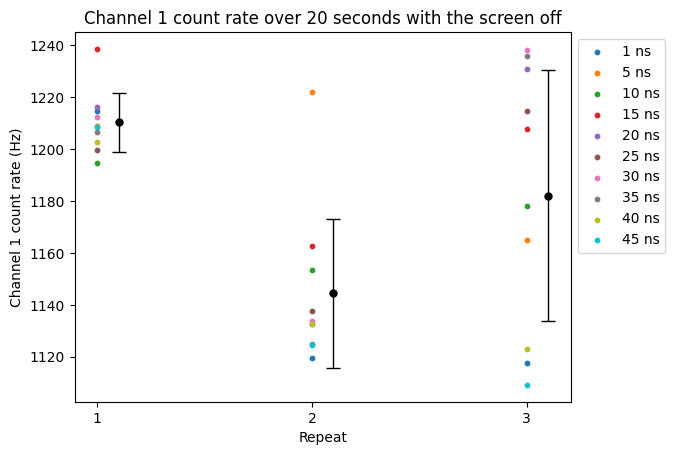

Average of the means: 1178.895 +- 15.586269598592242 Hz
Average stdev: 29.481017102826616 Hz


In [137]:
# Remove anomalies
new_screenoff_countdata_1 = screenoff_countdata_1[1:,1]
new_screenoff_countdata_2 = screenoff_countdata_2[1:,1]
new_screenoff_countdata_3 = screenoff_countdata_3[1:,1]

# PLot data
for i in range(10):
    plt.scatter(1, new_screenoff_countdata_1[i-1]/20, label = f"{ns_values[i]} ns", color=f"C{i}", s=10)
    plt.scatter(2, new_screenoff_countdata_2[i-1]/20, color=f"C{i}", s=10)
    plt.scatter(3, new_screenoff_countdata_3[i-1]/20, color=f"C{i}", s=10)


# Calculate means and stdevs of each repeat
means = np.array([np.mean(new_screenoff_countdata_1/20), np.mean(new_screenoff_countdata_2/20), np.mean(new_screenoff_countdata_3/20)])
stdevs = np.array([np.std(new_screenoff_countdata_1/20), np.std(new_screenoff_countdata_2/20), np.std(new_screenoff_countdata_3/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 1 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 1 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

To test this theory, lets graph the coincidence rates:

In [ ]:
# From the API, get the key:
CoincCounter_names = np.array(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','1/2','1/3','2/3','1/4','2/4','3/4','1/5','2/5','3/5','4/5','1/2/3','1/2/4','1/3/4','2/3/4','1/2/5','1/3/5','2/3/5','1/4/5','2/4/5','3/4/5','1/2/3/4','1/2/3/5','1/2/4/5','1/3/4/5','2/3/4/5','1/2/3/4/5'])


(array([33]),)
